In [1]:
#####Latent Gamma regression with Gibbs sampling#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####データの生成####
##データの設定
k = 5
hh = 3000
Lambda = np.random.gamma(30, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)
k_vec = np.repeat(1.0, k)

In [4]:
##IDとインデックスの定義
#IDの定義
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
#インデックスの設定
d_list = [i for i in range(hh)]
d_vec = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
    d_vec[i] = np.repeat(1.0, d_list[i].shape[0])

In [6]:
##入力と応答変数を生成
mag1 = 15; mag2 = 10

while True:
    #素性ベクトルを生成
    k1 = 3; k2 = 5; k3 = 5
    x1 = np.abs(np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1)))
    x2 = np.zeros((hhpt, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        x2[:, j] = np.random.binomial(1, prob, hhpt)
    x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
    x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
    x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
    col = x.shape[1]

    #モデルパラメータを生成
    
    theta = np.random.dirichlet(np.repeat(0.25, k), hh)
    beta0 = np.random.gamma(np.random.uniform(1.0, 30.0, k), 1/1.0, k)
    beta1 = np.array([np.abs(np.random.normal(beta0[j] / mag1, beta0[j] / mag2, col-1)) for j in range(k)])
    beta = np.hstack((beta0[:, np.newaxis], beta1))
    phi = np.random.normal(0.7, 0.75, k)
    kappa = np.exp(phi)
    beta = np.hstack((beta0[:, np.newaxis] , beta1))
    thetat = theta.copy(); betat = beta.copy(); phit = phi.copy()

    #ガンマ分布から応答変数を生成
    z, Z = rmnom(theta[d_id, ], hhpt, k, 1)   #トピックを生成
    mu1 = np.dot(x * beta[z, ], np.repeat(1.0, col))
    mu2 = beta0[z, ]
    y1 = np.random.gamma(kappa[z], mu1, hhpt)
    y2 = np.random.gamma(kappa[z], mu2, hhpt)
    y_log1 = np.log(y1)
    y_log2 = np.log(y2)

    #break条件
    if (np.max(y1) < 1500) & (np.std([np.mean(y1[z==j]) for j in range(k)]) >= 100):
        break

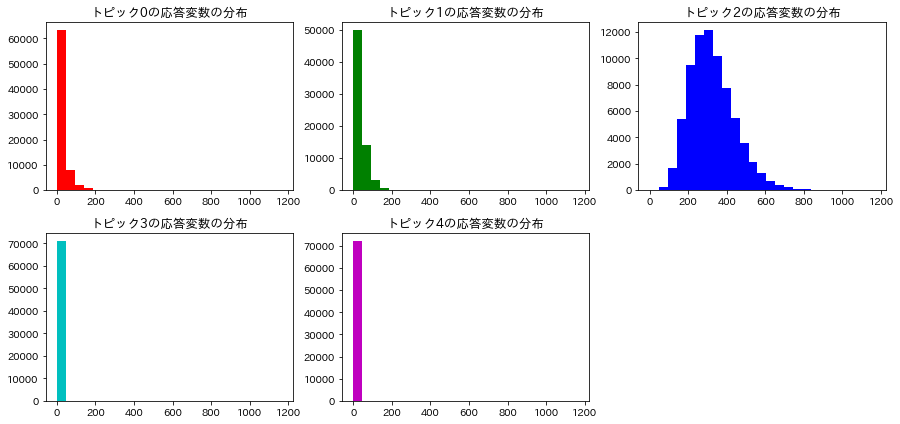

In [7]:
#生成したデータを可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(k):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(y1[z==j],  bins=25, range=(0, np.max(y1)), color=colorlist[j])
    plt.title("トピック" + str(j) + "の応答変数の分布", fontsize=12.5)
fig.tight_layout()
plt.show()

In [8]:
####ギブスサンプリングでパラメータをサンプリング####
##ガンマ分布のパラメータを推定するための関数
#ガンマ分布の確率密度関数
def Gamma_pdf(kappa, mu_vec, y_vec1):
    inv_Lambda = 1 / mu_vec
    Lho = (np.power(inv_Lambda, kappa) / scipy.special.gamma(kappa)) * np.power(y_vec1, kappa-1) * np.exp(-inv_Lambda*y_vec1)
    return Lho

#モデルの対数事後分布を定義
def loglike(phi, mu, delta, tau, y, y_log, index_z, k):
    #パラメータを定義
    kappa = np.exp(phi)
    
    #対数事後分布の和
    Posterior = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j] 
        inv_Lambda = 1 / mu[index]
        Lho = np.sum(kappa[j]*np.log(inv_Lambda) - scipy.special.loggamma(kappa[j]) + (kappa[j]-1)*y_log[index] - inv_Lambda*y[index])
        Prior = -1/2 * np.power(phi[j] - delta, 2) / tau
        Posterior[j] = Lho + Prior
    return Posterior

#形状パラメータの勾配ベクトル
def dll_kappa(phi, mu, delta, tau, y, y_log, index_z, k):
    #パラメータを定義
    kappa = np.exp(phi)

    #勾配ベクトルの和
    gradient = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j]
        inv_Lambda = 1 / mu[index]
        dll = np.sum(np.log(inv_Lambda) - scipy.special.digamma(kappa[j]) + y_log[index])
        dmv = -(phi[j] - delta) / tau
        gradient[j] = -(dll + dmv)
    return gradient

#リープフロッグ法を解く関数
def leapfrog_kappa(r, z1, D, e, L): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, mu, delta, tau, y1, y_log1, index_z, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, mu, delta, tau, y1, y_log1, index_z, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [9]:
##アルゴリズムの設定
#MCMCの設定
R = 1000
keep = 2
burnin = 500
iter = 0
disp = 50
e = 0.0005
L = 5

#事前分布の設定
alpha = 0.25
delta = 0.0
tau = 0.01
s0 = np.append(1.0, np.repeat(0.25, col-1))
v0 = np.append(1.0, np.repeat(0.25, col-1))

In [10]:
##パラメータの真値
#トピック分布の真値
theta = thetat.copy()
Zi = Z.copy()
z = np.dot(Zi, np.arange(k))
index_z = [np.array(np.where(z==j)[0], dtype="int") for j in range(k)]

#モデルパラメータの真値
beta = betat.copy()
phi = phit.copy()
kappa = np.exp(phi)

#期待値の真値
mu = np.dot(x * beta[z, ], np.repeat(1.0, col))
mut = np.dot(x, beta.T)

In [11]:
##パラメータの初期値
#トピック分布の初期値
theta = np.random.dirichlet(np.repeat(1.0, k), hh)
z, Zi = rmnom(theta[d_id, ], hhpt, k, 1)
index_z = [np.array(np.where(z==j)[0], dtype="int") for j in range(k)]

#モデルパラメータの初期値
beta0 = np.mean(y1) + np.random.normal(0, 5.0, k)
beta1 = np.random.gamma(1.0, 1/1.0, k*(col-1)).reshape(k, col-1)
beta = np.hstack((beta0[:, np.newaxis], beta1))
phi = np.repeat(1.0, k)
kappa = np.exp(phi)

#期待値の初期値
mu = np.dot(x * beta[z, ], np.repeat(1.0, col))

In [12]:
##パラメータの格納用配列
#モデルパラメータの格納用配列
THETA = np.zeros((hh, k, int(R/keep)))
BETA = np.zeros((k, col, int(R/keep)))
PHI = np.zeros((int(R/keep), k))

#トピックの格納用配列
SEG = np.zeros((hhpt, k))

In [13]:
##対数尤度の基準値
#基準パラメータでの対数尤度
LLst = np.sum(scipy.stats.gamma.logpdf(y1, 1.0, scale=np.mean(y1)))
print(LLst)

#真値での対数尤度
Posterior = thetat[d_id, ] * np.array([scipy.stats.gamma.pdf(y1, np.exp(phit[j]), scale=mut[:, j]) for j in range(k)]).T
LLbest = np.sum(np.log(np.sum(Posterior, axis=1)))
print(LLbest)

-1930466.87893093
-1597902.5995105288


In [14]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##潜在変数zをサンプリング
    #事後分布から割当確率を定義
    mu_vec = np.dot(x, beta.T)
    Lho = Gamma_pdf(kappa, mu_vec, y1[:, np.newaxis])
    Posterior = theta[d_id, ] * Lho
    Prob = Posterior / np.dot(Posterior, k_vec)[:, np.newaxis]

    #多項分布からトピックをサンプリング
    z, Zi = rmnom(Prob, hhpt, k, 1)
    topic_n = np.sum(Zi, axis=0)
    index_z = [np.array(np.where(z==j)[0], dtype="int") for j in range(k)]


    ##トピック分布をサンプリング
    #ディリクリ分布のパラメータ
    wsums = np.zeros((hh, k))
    for i in range(hh):
        wsums[i, ] = np.dot(Zi[d_list[i], ].T, d_vec[i]) + alpha
        theta[i, ] = np.random.dirichlet(wsums[i, ], 1).reshape(-1)


    ##回帰係数をサンプリング
    #補助変数を更新
    mu_deploy = x * beta[z, ]
    mu = np.sum(mu_deploy, axis=1)
    Lambda = mu_deploy / mu[:, np.newaxis]

    #ガンマ分布からパラメータをサンプリング
    for j in range(k):
        index = index_z[j]
        s = np.sum(y1[index, np.newaxis] * Lambda[index, ] , axis=0) + s0
        v = kappa[j] * np.sum(x[index, ], axis=0) + v0
        beta[j, ] = np.random.gamma(s, 1/v, col)


    ##形状パラメータをサンプリング
    #リープフロッグ法で新しいパラメータをサンプリング
    rold = np.random.normal(0, 1.0, k)
    phid = phi.copy()
    res = leapfrog_kappa(rold, phid, dll_kappa, e, L)
    rnew = res[0]
    phin = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike(phin, mu, delta, tau, y1, y_log1, index_z, k)
    Hold = -loglike(phid, mu, delta, tau, y1, y_log1, index_z, k)

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, k)
    gamma = np.exp(Hold - Hnew); gamma[gamma > 1.0] = 1.0
    accept_prob = gamma.copy()
    flag = np.array(gamma > rand, dtype="int")
    phi = flag*phin + (1-flag)*phid
    kappa = np.exp(phi)


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA[:, :, mkeep] = theta
        BETA[:, :, mkeep] = beta
        PHI[mkeep, ] = phi 

    #トピックを格納
    if (rp%keep==0) & (burnin >= rp):
        SEG += Zi

    #対数尤度の更新とサンプリング結果の表示
    if rp%disp==0:
        #対数尤度を更新
        LL = np.sum(np.log(np.sum(Posterior, axis=1)))

        #サンプリング結果の表示
        print(rp)
        print(np.round(accept_prob, 3))
        print(np.round(np.append(np.exp(phi), np.exp(phit)), 3))
        print(np.round([LL, LLst, LLbest], 1))

0
[1. 1. 1. 1. 1.]
[1.67  1.619 1.722 1.393 1.661 0.494 1.277 8.197 3.389 1.093]
[-3104711.2 -1930466.9 -1597902.6]
50
[0.826 1.    1.    1.    0.719]
[1.324 1.287 3.924 0.9   1.4   0.494 1.277 8.197 3.389 1.093]
[-1621713.7 -1930466.9 -1597902.6]
100
[1.    1.    1.    1.    0.475]
[1.292 2.065 5.276 0.747 1.392 0.494 1.277 8.197 3.389 1.093]
[-1606858.6 -1930466.9 -1597902.6]
150
[1.    1.    1.    0.637 1.   ]
[1.246 2.521 6.177 0.714 1.32  0.494 1.277 8.197 3.389 1.093]
[-1603089.7 -1930466.9 -1597902.6]
200
[0.978 0.213 1.    1.    1.   ]
[1.212 2.767 6.912 0.708 1.263 0.494 1.277 8.197 3.389 1.093]
[-1601701.7 -1930466.9 -1597902.6]
250
[1.    0.87  0.    0.664 0.188]
[1.157 2.891 7.307 0.706 1.231 0.494 1.277 8.197 3.389 1.093]
[-1601190.1 -1930466.9 -1597902.6]
300
[1.    0.036 0.15  0.739 0.114]
[1.147 3.01  7.575 0.711 1.2   0.494 1.277 8.197 3.389 1.093]
[-1600908.9 -1930466.9 -1597902.6]
350
[1.    0.878 0.883 1.    1.   ]
[1.106 3.053 7.781 0.71  1.182 0.494 1.277 8.197 3.